In [2]:
import pandas as pd
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from prophet import Prophet
%matplotlib inline
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Gas Natural

In [3]:
gasn = pd.read_csv('data_materias_eur/GAS-EUR.csv')

In [4]:
gasn = gasn.drop(columns=['Open','High', 'Low', 'Adj Close', 'Volume' ])  #eliminamos columnas innecesarias

gasn['Date'] = pd.to_datetime(gasn['Date'])  #convertimos a fecha

In [5]:

gasn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1976 entries, 0 to 1975
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1976 non-null   datetime64[ns]
 1   Close   1976 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.0 KB


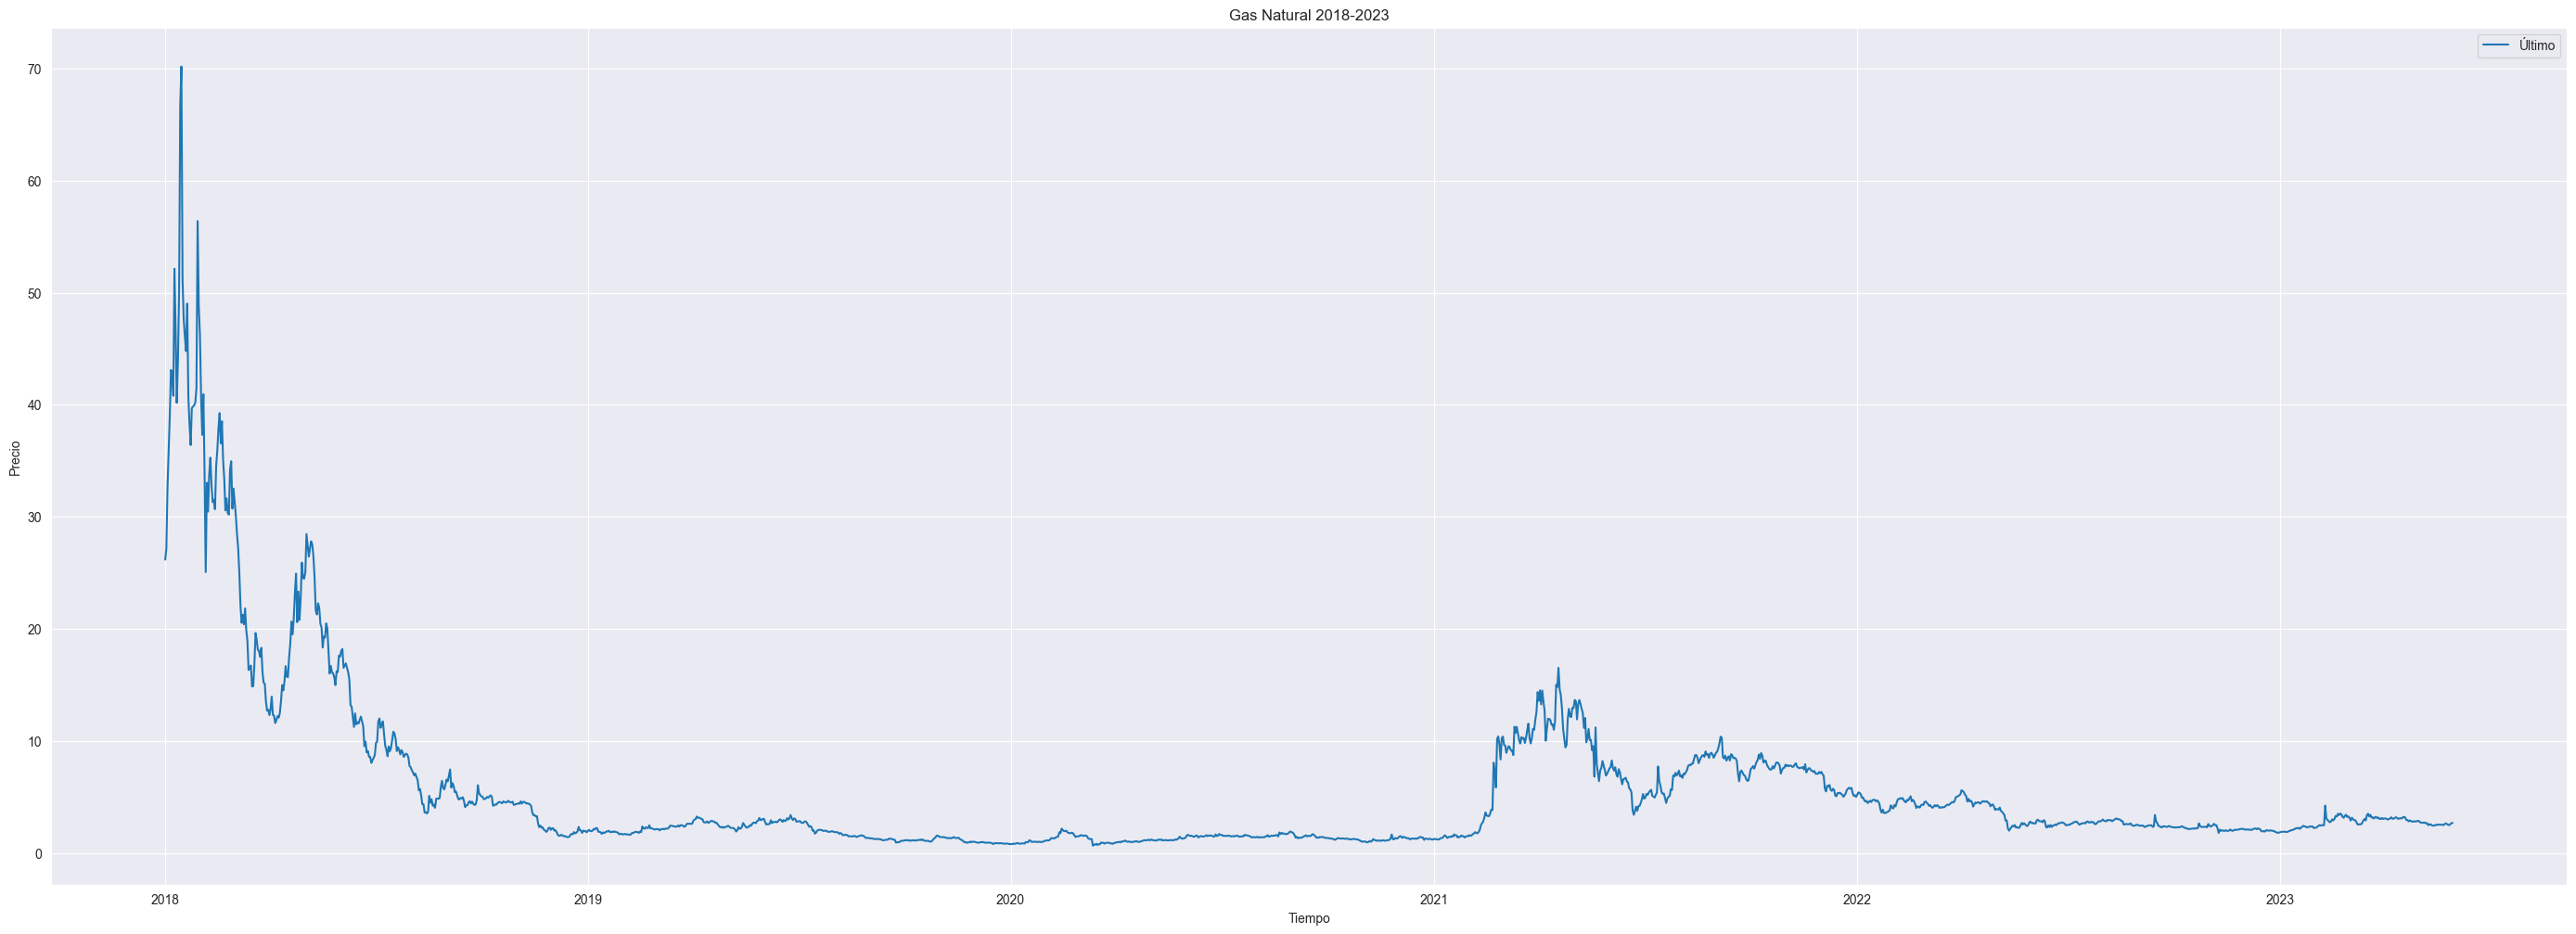

In [6]:
fig = plt.figure(figsize=(35,12))
sns.set_style("darkgrid")

sns.lineplot(x=gasn.Date,y=gasn['Close'], data=gasn['Close'])

plt.title('Gas Natural 2018-2023')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend(['Último'])

plt.show()

Relleno los fines de semana

In [7]:
import datetime

In [8]:
gasn = gasn.set_index('Date')
date_range = pd.date_range(start=gasn.index.min(), end=gasn.index.max())
filled_gasn = pd.merge(pd.DataFrame(date_range, columns=['Date']), gasn, how='left', left_on='Date', right_index=True)

filled_gasn = filled_gasn.fillna(method='ffill')



In [9]:
filled_gasn.head()

,Date,Close
0,2018-01-01,26.183029
1,2018-01-02,27.124121
2,2018-01-03,32.633389
3,2018-01-04,35.773663
4,2018-01-05,39.078068


Test DickeyFuller

In [10]:
from statsmodels.tsa.stattools import adfuller

y = filled_gasn.Close
result = adfuller(y)
print('Dickey-Fuller Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Dickey-Fuller Statistic: -5.452756
p-value: 0.000003
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Dickey-Fuller me dice que es estacionaria por lo tanto se debería poder hacer el modelo con ARIMA 

### Modelo de kaggle

Sacarme columna de año mes y dia

In [11]:
filled_gasn['year'] = filled_gasn['Date'].dt.year
filled_gasn['month'] = filled_gasn['Date'].dt.month
filled_gasn['day'] = filled_gasn['Date'].dt.day

filled_gasn.isnull().sum()

Date     0
Close    0
year     0
month    0
day      0
dtype: int64

Sacar X e y

In [12]:
x = filled_gasn.iloc[:, -3:].values  #input
y = filled_gasn.iloc[:, 1].values #output price only

In [13]:
x

array([[2018,    1,    1],
       [2018,    1,    2],
       [2018,    1,    3],
       ...,
       [2023,    5,   28],
       [2023,    5,   29],
       [2023,    5,   30]], dtype=int64)

In [14]:
y

array([26.183029, 27.124121, 32.633389, ...,  2.587448,  2.688613,
        2.700953])

In [15]:
filled_gasn.tail(4)

,Date,Close,year,month,day
1972,2023-05-27,2.505847,2023,5,27
1973,2023-05-28,2.587448,2023,5,28
1974,2023-05-29,2.688613,2023,5,29
1975,2023-05-30,2.700953,2023,5,30


In [16]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=5,shuffle=False)

y_test

array([2.545363, 2.505847, 2.587448, 2.688613, 2.700953])

### Decision Tree Regressor

In [17]:
#import decision tree regressor
from sklearn.tree import DecisionTreeRegressor
dtr=DecisionTreeRegressor()
#fitting the model or training the model
dtr.fit(x_train,y_train)

DecisionTreeRegressor()

In [18]:
y_pred=dtr.predict(x_test)
y_pred;

In [19]:
from sklearn.metrics import r2_score
accuracy=r2_score(y_test,y_pred)
accuracy

-0.5628005507575704

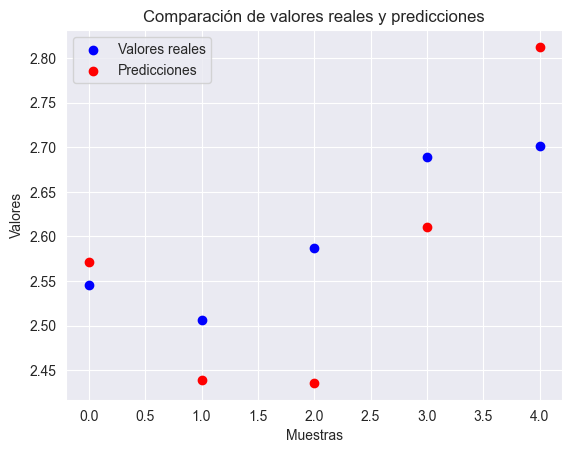

In [20]:
# gráfico de dispersión
plt.scatter(range(len(y_test)), y_test, color='blue', label='Valores reales')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicciones')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.title('Comparación de valores reales y predicciones')
plt.legend()
plt.show()

In [21]:
y_test

array([2.545363, 2.505847, 2.587448, 2.688613, 2.700953])

XGBOOST

XGBRegressor (XGBR): XGBR es una implementación del algoritmo de refuerzo llamado Extreme Gradient Boosting (XGBoost). Es similar a GBR, pero utiliza una técnica de refuerzo mejorada y optimizaciones adicionales para lograr un rendimiento más rápido y preciso. XGBoost ha demostrado ser eficaz en una amplia gama de problemas de aprendizaje automático y es ampliamente utilizado en competencias de Kaggle.



XGBRegressor(n_estimators=100)

In [22]:
from xgboost import XGBRegressor as XGBR

In [23]:
xgbr=XGBR()
xgbr.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [24]:
y_pred=xgbr.predict(x_test)

mean_squared_error(y_test, y_pred, squared=False)  # RMSE

0.1258590053674676

In [25]:
y_test

array([2.545363, 2.505847, 2.587448, 2.688613, 2.700953])

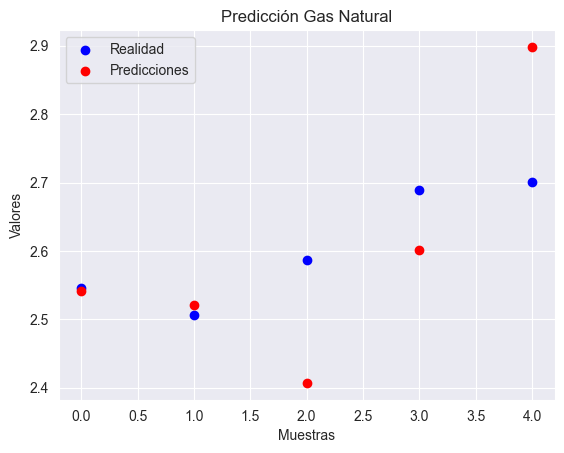

In [26]:
# gráfico de dispersión
plt.scatter(range(len(y_test)), y_test, color='blue', label='Realidad')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicciones')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.title('Predicción Gas Natural')
plt.legend()
plt.show()

Predicciones a un solo día 

## ARIMA

In [27]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


#poner el limite de división

fecha = pd.to_datetime('2023-05-24')
index = filled_gasn[filled_gasn['Date'] <= fecha]['Date'].idxmax()

#Dividir en conjuntos de entrenamiento y prueba
train_gasn = filled_gasn[:index]
test_gasn = filled_gasn[index:]



## SARIMA

En el caso de SARIMAX, los parámetros order se refieren a la componente no estacional del modelo, mientras que seasonal_order se refiere a la componente estacional del modelo.

El parámetro order se especifica como (p, d, q), donde:

- p es el orden del componente autoregresivo (AR). Representa la dependencia lineal de la variable con sus valores pasados. Un valor típico podría ser 1 o 2.

- d es el orden de diferenciación. Representa la cantidad de veces que se deben tomar diferencias para hacer que los datos sean estacionarios. Si los datos ya son estacionarios, d=0. En caso contrario, se puede probar con d=1 o d=2 para eliminar tendencias o patrones de crecimiento.

- q es el orden del componente de promedio móvil (MA). Representa la dependencia lineal de la variable con los errores pasados. Un valor típico podría ser 1 o 2.

El parámetro seasonal_order se especifica como (P, D, Q, S), donde:

- P es el orden del componente estacional autoregresivo (SAR). Captura la dependencia lineal de la variable con sus valores pasados en un período estacional.

- D es el orden de diferenciación estacional. Representa la cantidad de veces que se deben tomar diferencias estacionales para hacer que los datos sean estacionarios.

- Q es el orden del componente estacional de promedio móvil (SMA). Captura la dependencia lineal de la variable con los errores pasados en un período estacional.

- S es la longitud de la estacionalidad, es decir, la cantidad de periodos en una estación completa. Por ejemplo, si los datos tienen una estacionalidad anual, S=12 para datos mensuales.

In [28]:
'''
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar el modelo SARIMA con un paso de tiempo diario
model = SARIMAX(train_gasn['Close'], order=(1, 1, 1), seasonal_order=(150, 0, 1, 7))
model_fit = model.fit()

# predicciones en el conjunto de prueba
predictions = model_fit.predict(start=index, end=len(filled_gasn)-1, dynamic=False)

# Calcular el error cuadrático medio (RMSE)
rmse = mean_squared_error(test_gasn['Close'], predictions, squared=False)
print('Test RMSE: %.3f' % rmse)

# Graficar las predicciones contra los valores reales

# Establecer el estilo y el contexto de Seaborn
sns.set(style='darkgrid', context='paper')

# Crear una figura con un tamaño personalizado
plt.figure(figsize=(10, 6))

# Tramar el conjunto de prueba y las predicciones
sns.lineplot(data=test_gasn['Close'], color='blue')
sns.lineplot(data=predictions, color='red')

plt.title('Predicciones vs. Conjunto de prueba')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend(['Conjunto de prueba', 'Predicciones'])

plt.tight_layout()  # Ajustar el espaciado de los elementos del gráfico
plt.show()
'''

"\nfrom statsmodels.tsa.statespace.sarimax import SARIMAX\n\n# Ajustar el modelo SARIMA con un paso de tiempo diario\nmodel = SARIMAX(train_gasn['Close'], order=(1, 1, 1), seasonal_order=(150, 0, 1, 7))\nmodel_fit = model.fit()\n\n# predicciones en el conjunto de prueba\npredictions = model_fit.predict(start=index, end=len(filled_gasn)-1, dynamic=False)\n\n# Calcular el error cuadrático medio (RMSE)\nrmse = mean_squared_error(test_gasn['Close'], predictions, squared=False)\nprint('Test RMSE: %.3f' % rmse)\n\n# Graficar las predicciones contra los valores reales\n\n# Establecer el estilo y el contexto de Seaborn\nsns.set(style='darkgrid', context='paper')\n\n# Crear una figura con un tamaño personalizado\nplt.figure(figsize=(10, 6))\n\n# Tramar el conjunto de prueba y las predicciones\nsns.lineplot(data=test_gasn['Close'], color='blue')\nsns.lineplot(data=predictions, color='red')\n\nplt.title('Predicciones vs. Conjunto de prueba')\nplt.xlabel('Índice')\nplt.ylabel('Valor')\nplt.legend(

Divido en train y test

In [29]:
#limite de división

fecha = pd.to_datetime('2023-05-24')
index = filled_gasn[filled_gasn['Date'] <= fecha]['Date'].idxmax()

#Dividir en conjuntos de entrenamiento y prueba
train_gasn = filled_gasn[:index]
test_gasn = filled_gasn[index:]

## Prophet

In [30]:
train_data = train_gasn[['Date', 'Close']].copy()
train_data.columns = ['ds', 'y']

train_data.head()

,ds,y
0,2018-01-01,26.183029
1,2018-01-02,27.124121
2,2018-01-03,32.633389
3,2018-01-04,35.773663
4,2018-01-05,39.078068


In [31]:
# creo instancia de prophet y entreno el modelo

model = Prophet()
model.fit(train_data)

# que me haga predicciones sobre mi test
future = model.make_future_dataframe(periods=len(test_gasn), freq='D')

#dataframe de predicciones
forecast = model.predict(future)

12:04:24 - cmdstanpy - INFO - Chain [1] start processing
12:04:25 - cmdstanpy - INFO - Chain [1] done processing


### Gráficando resultados

C:\Users\river\AppData\Local\Temp\ipykernel_23084\2781890711.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
C:\Users\river\AppData\Local\Temp\ipykernel_23084\2781890711.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


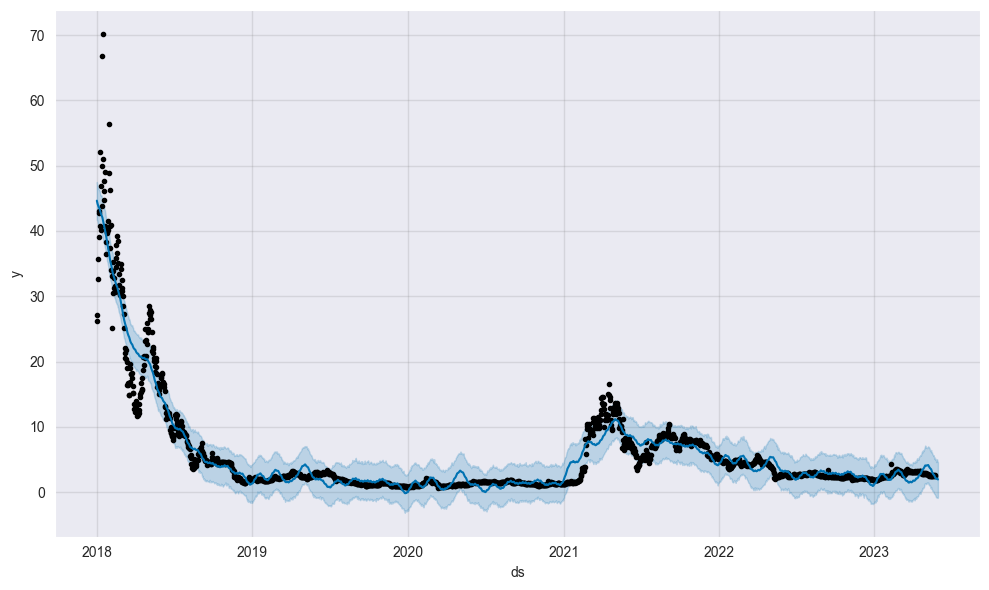

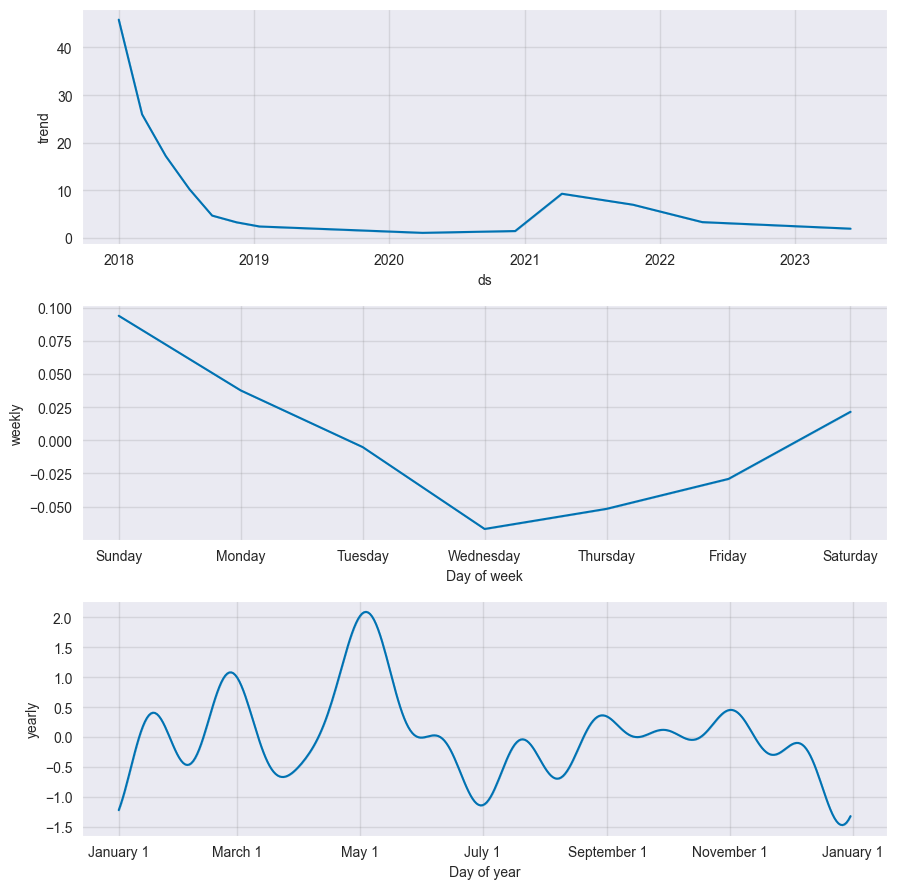

In [32]:
from prophet.plot import plot_plotly, plot_components_plotly

# visulización de las predicciones
fig1 = model.plot(forecast)

# Visualización de los componentes del modelo
fig2 = model.plot_components(forecast)


fig1.show()
fig2.show()

Gráfico de las predicciones:
Este gráfico muestra los datos históricos junto con las predicciones realizadas por el modelo. La línea azul representa los datos observados en el conjunto de entrenamiento, mientras que la línea negra muestra las predicciones realizadas por el modelo. El área sombreada en azul claro representa el intervalo de confianza al 95% de las predicciones.

Gráfico de los componentes del modelo:
Este gráfico descompone la serie temporal en sus componentes principales: tendencia, estacionalidad y efectos de días festivos. El gráfico muestra tres subgráficos:
El primer subgráfico muestra la tendencia, que es una estimación de la dirección general en la que se mueve la serie temporal a largo plazo.
El segundo subgráfico muestra la estacionalidad, que representa los patrones recurrentes o estacionales en los datos.
El tercer subgráfico muestra los efectos de los días festivos, que capturan las desviaciones específicas relacionadas con días festivos u otras ocasiones especiales.

In [33]:
test_gasn

,Date,Close,year,month,day
1969,2023-05-24,2.659774,2023,5,24
1970,2023-05-25,2.610458,2023,5,25
1971,2023-05-26,2.545363,2023,5,26
1972,2023-05-27,2.505847,2023,5,27
1973,2023-05-28,2.587448,2023,5,28
1974,2023-05-29,2.688613,2023,5,29
1975,2023-05-30,2.700953,2023,5,30


In [34]:
#  valores reales del conjunto de prueba
test_values = test_gasn['Close'].values

#  predicciones de Prophet
predicted_values = forecast['yhat'].values[-len(test_values):]

df_comparisongn = pd.DataFrame({'Predicciones': predicted_values, 'Valores Reales': test_values})


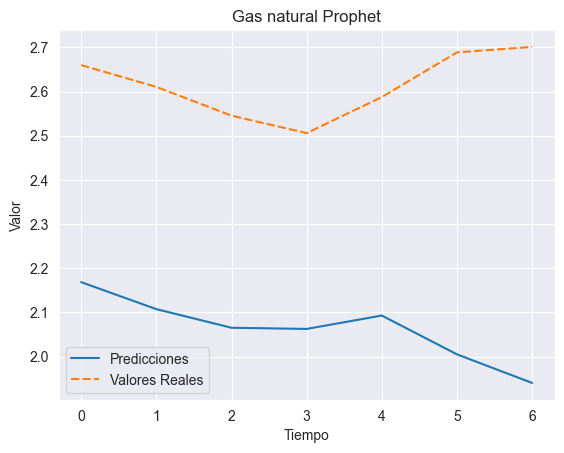

In [35]:
# gráfico  con las predicciones y los valores reales
sns.lineplot(data=df_comparisongn)

plt.title('Gas natural Prophet')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.show()

Evaluar el modelo

In [36]:
# Calcular el MAE
mae = mean_absolute_error(test_values, predicted_values)

# Calcular el MSE
mse = mean_squared_error(test_values, predicted_values)

# Calcular el RMSE
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)


MAE: 0.5509543624691491
MSE: 0.3160047618201488
RMSE: 0.5621430083352


MAE (Mean Absolute Error): Es el error absoluto promedio entre las predicciones y los valores reales. Representa la diferencia promedio entre las predicciones y los valores reales, sin tener en cuenta la dirección de la diferencia. Cuanto menor sea el valor del MAE, mejor será el ajuste del modelo.

MSE (Mean Squared Error): Es el error cuadrático promedio entre las predicciones y los valores reales. Calcula la diferencia cuadrática promedio entre las predicciones y los valores reales, lo que da más peso a las diferencias más grandes. Cuanto menor sea el valor del MSE, mejor será el ajuste del modelo.

RMSE (Root Mean Squared Error): Es la raíz cuadrada del MSE y representa el error promedio entre las predicciones y los valores reales en la misma escala que los datos originales. El RMSE se utiliza comúnmente para interpretar el error de predicción en la misma unidad que los datos originales. Cuanto menor sea el valor del RMSE, mejor será el ajuste del modelo.

En resumen, estos resultados indican que el modelo de Prophet tiene un error promedio absoluto (MAE) de 0.5509, un error cuadrático promedio (MSE) de 0.3160 y un error cuadrático promedio raíz (RMSE) de 0.5621. Cuanto más cercanos a cero sean estos valores, mejor será el rendimiento del modelo en la predicción de los valores reales.

### Conclusiones Gas Natural

Esta subida de precios del gas natural en 2022 se debe a la invasión de Ucrania por parte de Rusia que ha afectado al mercado eneerg´rtico

Dado que las energías reonvables no pueden atender toda la demanda, necesitamos combstibles fósiles para producir electricidad

No solo esto si no que otra circunstancia que afecta a su precio es que ha caído la oferta
Causas del aumento de la demanda mundial de gas natural:
- demanda post-pandemia ha ido creciendo
- Europa utiliza gas natural para calentar las viviendas
- Cierre de plantas nucleares y de carbón

# Precio del Uranio

In [37]:
uranio = pd.read_csv('data_materias/uranio.csv')
uranio = uranio.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])

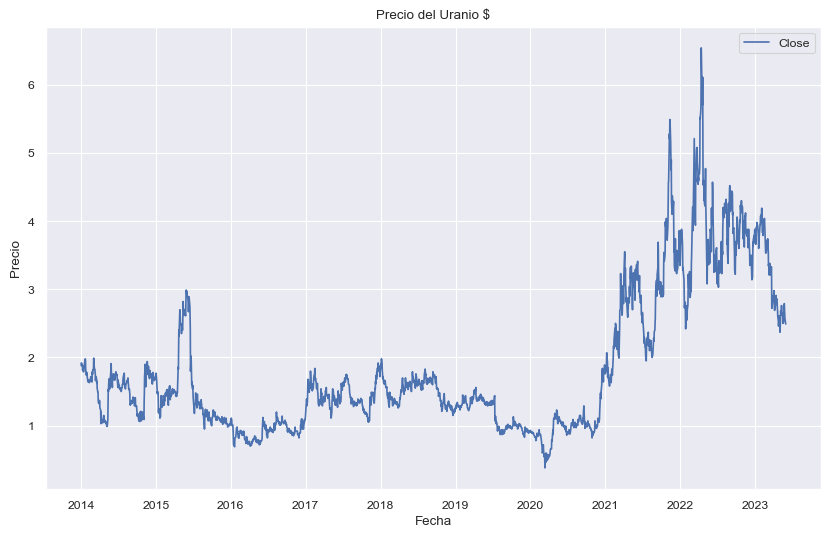

In [38]:
uranio['Date'] = pd.to_datetime(uranio['Date'])

# Establecer el estilo y el contexto de Seaborn
sns.set(style='darkgrid', context='paper')

# Crear una figura con un tamaño personalizado
plt.figure(figsize=(10, 6))

sns.lineplot(x=uranio.Date,y=uranio['Close'], data=uranio['Close'])

plt.title('Precio del Uranio $')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend(['Close'])

plt.show()

Filtro a partir de 2018

In [39]:
# Filtrar los datos desde 2018 en adelante
uranio = uranio[uranio['Date'] >= '2018-01-01']

In [40]:
uranio

,Date,Close
1007,2018-01-02,1.90
1008,2018-01-03,1.85
1009,2018-01-04,1.94
1010,2018-01-05,1.98
1011,2018-01-08,1.91
...,...,...
2363,2023-05-23,2.79
2364,2023-05-24,2.69
2365,2023-05-25,2.64
2366,2023-05-26,2.57


In [41]:
uranio = uranio.set_index('Date')
date_range = pd.date_range(start=uranio.index.min(), end=uranio.index.max())
filled_uranio = pd.merge(pd.DataFrame(date_range, columns=['Date']), uranio, how='left', left_on='Date', right_index=True)

filled_uranio = filled_uranio.fillna(method='ffill')


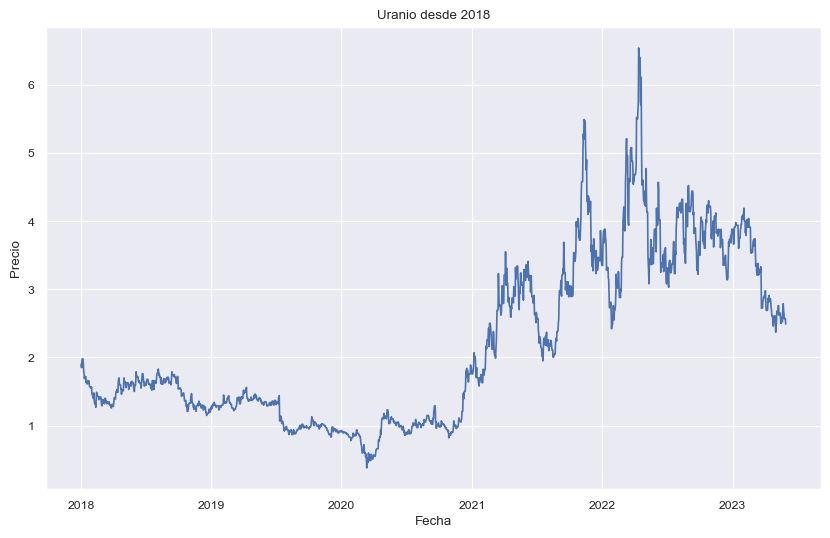

In [42]:
# Visualizar los datos filtrados
sns.set(style='darkgrid', context='paper')
plt.figure(figsize=(10, 6))
sns.lineplot(x=filled_uranio['Date'], y=filled_uranio['Close'])
plt.title('Uranio desde 2018')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.show()

Utilizo el mismo modelo que he empleado para las predicciones del gas natural con Prophet

In [43]:
#poner el limite de división

# Establecer la fecha límite para la división
fecha = pd.to_datetime('2023-05-24')

# Obtener el índice máximo que cumpla la condición de fecha límite
index = filled_uranio[filled_uranio['Date'] <= fecha]['Date'].idxmax()

# Dividir en conjuntos de entrenamiento y prueba
train_uranio = filled_uranio[:index]
test_uranio = filled_uranio[index:]



In [44]:

## Prophet
train_data = train_uranio[['Date', 'Close']].copy()
train_data.columns = ['ds', 'y']

train_data.head()
# creo instancia de prophet y entreno el modelo

model = Prophet()
model.fit(train_data)

# que me haga predicciones sobre mi test
future = model.make_future_dataframe(periods=len(test_uranio), freq='D')   # test uranio está vacío, no está haciendo predicciones futuras

#dataframe de predicciones
forecast = model.predict(future)


12:04:28 - cmdstanpy - INFO - Chain [1] start processing
12:04:28 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
train_uranio.tail()

,Date,Close
1963,2023-05-19,2.53
1964,2023-05-20,2.53
1965,2023-05-21,2.53
1966,2023-05-22,2.73
1967,2023-05-23,2.79


Gráficando resultados

C:\Users\river\AppData\Local\Temp\ipykernel_23084\329044645.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
C:\Users\river\AppData\Local\Temp\ipykernel_23084\329044645.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


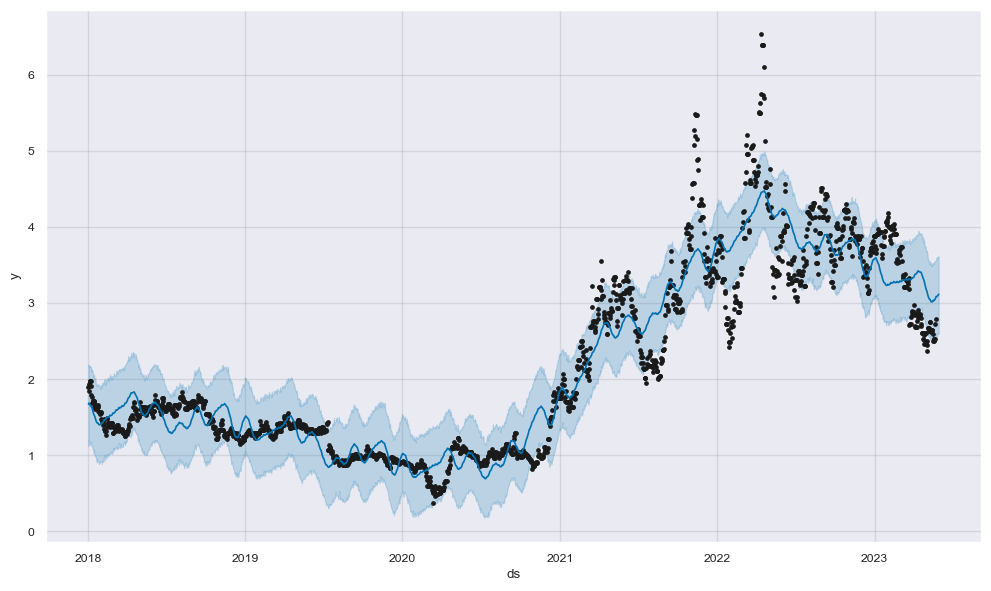

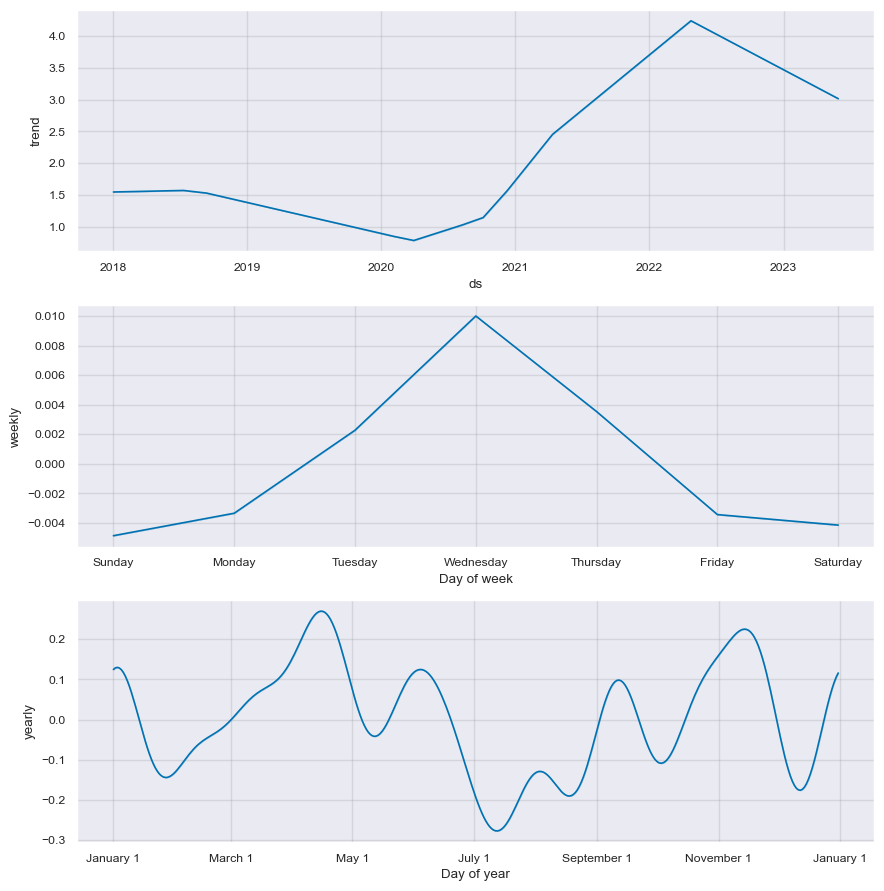

In [46]:
# visulización de las predicciones
fig1 = model.plot(forecast)

# Visualización de los componentes del modelo
fig2 = model.plot_components(forecast)


fig1.show()
fig2.show()


In [47]:
# valores reales del conjunto de prueba
test_values = train_uranio['Close'].values

# predicciones de Prophet
predicted_values = forecast['yhat'].values[-len(test_values):]

In [48]:
# Crear un DataFrame con las dos columnas
df_comparison = pd.DataFrame({'Predicciones': predicted_values, 'Valores Reales': test_values})

df_comparison.tail()

,Predicciones,Valores Reales
1963,3.089777,2.53
1964,3.096257,2.53
1965,3.102005,2.53
1966,3.109116,2.73
1967,3.119329,2.79


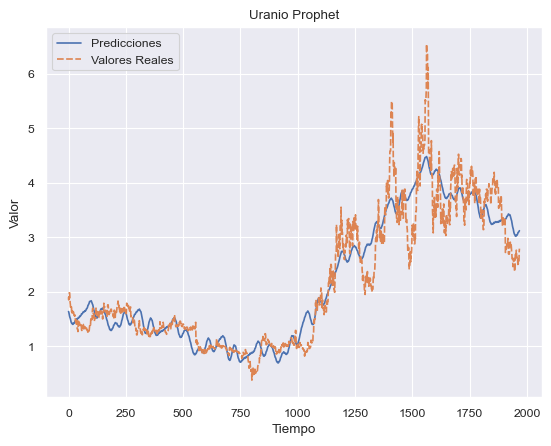

In [49]:
# gráfico l con las predicciones y los valores reales
sns.lineplot(data=df_comparison)

plt.title('Uranio Prophet')
plt.xlabel('Tiempo')
plt.ylabel('Valor')

plt.show()

Evaluar el modelo

In [50]:

# Calcular el MAE
mae = mean_absolute_error(test_values, predicted_values)

# Calcular el MSE
mse = mean_squared_error(test_values, predicted_values)

# Calcular el RMSE
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)


MAE: 0.28529821240702397
MSE: 0.15712753227843093
RMSE: 0.39639315367250094


## Precio del Uranio con XGB

In [51]:
filled_uranio['year'] = filled_uranio['Date'].dt.year
filled_uranio['month'] = filled_uranio['Date'].dt.month
filled_uranio['day'] = filled_uranio['Date'].dt.day

In [52]:
x = filled_uranio.iloc[:, -3:].values  #input
y = filled_uranio.iloc[:, 1].values #output price only

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=5,shuffle=False)

XGBOOST

XGBRegressor (XGBR): XGBR es una implementación del algoritmo de refuerzo llamado Extreme Gradient Boosting (XGBoost). Es similar a GBR, pero utiliza una técnica de refuerzo mejorada y optimizaciones adicionales para lograr un rendimiento más rápido y preciso. XGBoost ha demostrado ser eficaz en una amplia gama de problemas de aprendizaje automático y es ampliamente utilizado en competencias de Kaggle.


In [53]:
xgbr=XGBR()
xgbr.fit(x_train, y_train)
y_pred=xgbr.predict(x_test)

mean_squared_error(y_test, y_pred, squared=False)  # RMSE


0.408220156681049

In [54]:
y_pred

array([2.8392246, 2.9587967, 2.9845524, 3.0019627, 2.991127 ],
      dtype=float32)

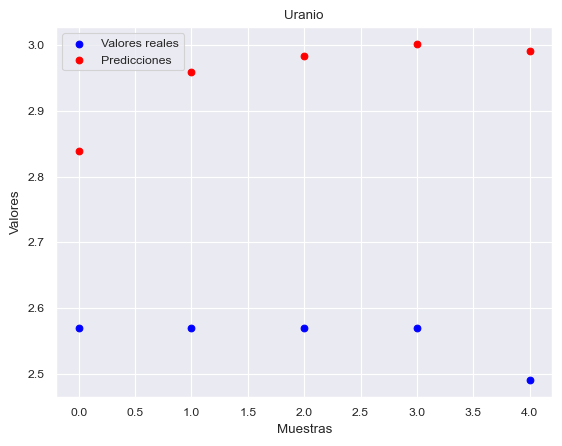

In [55]:

# gráfico de dispersión
plt.scatter(range(len(y_test)), y_test, color='blue', label='Valores reales')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicciones')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.title('Uranio')
plt.legend()
plt.show()


Para el uranio XGB Regressor no funciona tan bien

## Generación de renovables

In [56]:
renovables = pd.read_csv('clean_data/renovables.csv')

# Paso 1: Eliminar la columna "Hidroeólica" y el Indice
renovables = renovables.drop('Unnamed: 0', axis=1)
renovables = renovables.drop('Hidroeólica', axis=1)

# Paso 2: Crear la nueva columna "Solar" como la suma de "Solar fotovoltaica" y "Solar térmica"
renovables['Solar'] = renovables['Solar fotovoltaica'] + renovables['Solar térmica']

# Paso 3: Eliminar las columnas "Solar fotovoltaica" y "Solar térmica"
renovables = renovables.drop(['Solar fotovoltaica', 'Solar térmica'], axis=1)

# Convertir la columna "Fecha" a datetime
renovables['Fecha'] = pd.to_datetime(renovables['Fecha'], format='%d/%m/%Y')


In [57]:
renovables.head()

,Fecha,Hidráulica,Eólica,Otras renovables,Residuos renovables,Solar
0,2020-01-01,151.481978,23.525794,8.373805,2.454439,27.960236
1,2020-01-02,159.171675,77.426389,8.407882,2.115271,22.901504
2,2020-01-03,151.996921,84.099112,8.992384,2.115966,18.079815
3,2020-01-04,139.873002,125.320489,9.549843,2.221634,24.877053
4,2020-01-05,126.801179,61.809342,10.030028,2.247091,32.125610


In [58]:
renovables['year'] = renovables['Fecha'].dt.year
renovables['month'] = renovables['Fecha'].dt.month
renovables['day'] = renovables['Fecha'].dt.day

### Predicciones con XGB REGRESSOR

RMSE para la columna "Hidráulica": 19.5748204455532


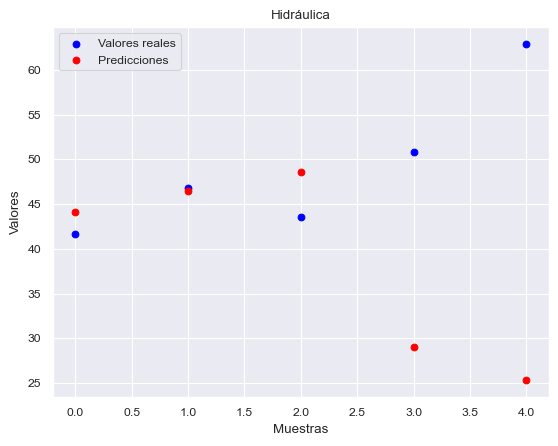

RMSE para la columna "Eólica": 122.31533501167414


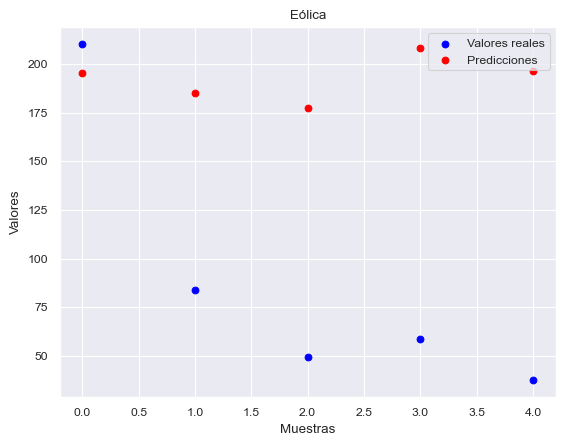

RMSE para la columna "Solar": 40.23307902008423


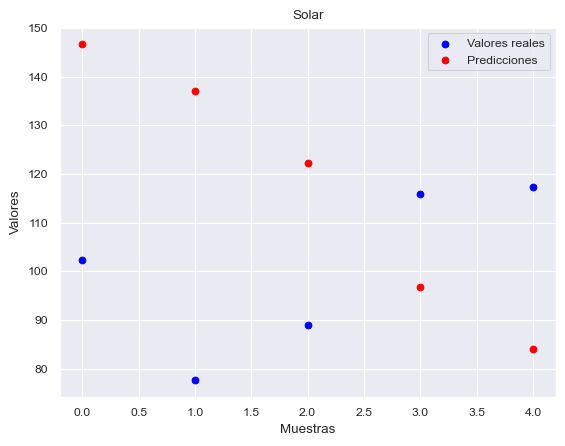

RMSE para la columna "Otras renovables": 0.6359608202312316


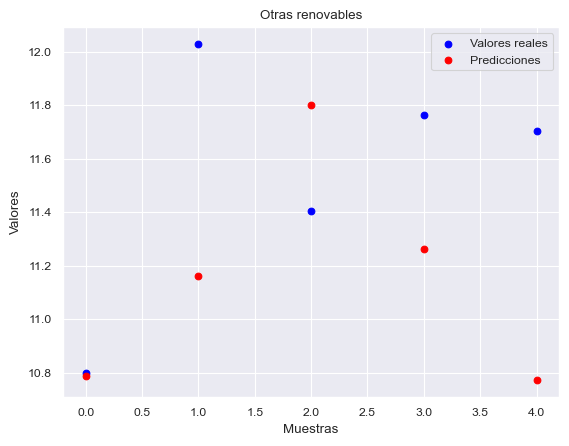

RMSE para la columna "Residuos renovables": 0.4624408882264266


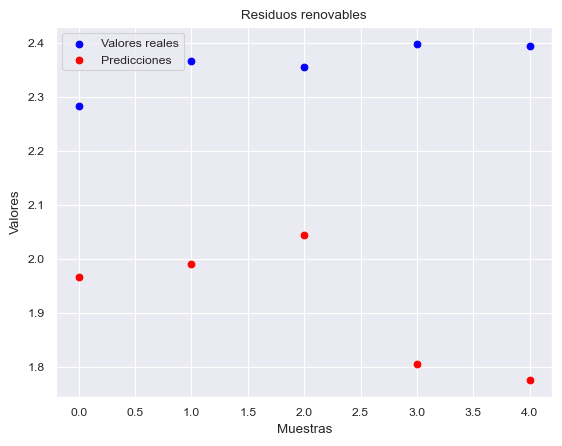

In [59]:
# Diccionario para almacenar las predicciones
predicciones = {}

# Obtener las columnas de potencia generada
columnas_potencia = ['Hidráulica', 'Eólica', 'Solar', 'Otras renovables', 'Residuos renovables']

for columna in columnas_potencia:
    # Definir los datos de entrada (x) y salida (y) para la columna actual
    x = renovables[['year', 'month', 'day']].values
    y = renovables[columna].values
    
    # Dividir los datos en conjunto de entrenamiento y prueba
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=5, shuffle=False)
    
    # Crear el modelo XGBRegressor
    xgbr = XGBR()
    
    # Entrenar el modelo
    xgbr.fit(x_train, y_train)
    
    # Realizar predicciones en el conjunto de prueba
    y_pred = xgbr.predict(x_test)
    
    # Calcular el error RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f'RMSE para la columna "{columna}": {rmse}')
    
    # Almacenar las predicciones en el diccionario
    predicciones[columna] = y_pred

    # Graficar los valores reales y las predicciones
    plt.scatter(range(len(y_test)), y_test, color='blue', label='Valores reales')
    plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicciones')
    plt.xlabel('Muestras')
    plt.ylabel('Valores')
    plt.title(columna)
    plt.legend()
    plt.show()

# Convertir el diccionario en un DataFrame
df_predicciones = pd.DataFrame(predicciones)


In [60]:
df_predicciones

,Hidráulica,Eólica,Solar,Otras renovables,Residuos renovables
0,44.072075,195.408463,146.725082,10.787475,1.967151
1,46.496578,185.201920,137.039978,11.159973,1.991455
2,48.540817,177.715302,122.276199,11.799983,2.044088
3,28.988010,208.551620,96.845352,11.262226,1.806213
4,25.340763,196.679733,83.984886,10.772620,1.775996


In [61]:
renovables.tail(5)

,Fecha,Hidráulica,Eólica,Otras renovables,Residuos renovables,Solar,year,month,day
1241,2023-05-26,41.6624,210.392500,10.79782,2.282750,102.242471,2023,5,26
1242,2023-05-27,46.7669,83.687496,12.02782,2.365950,77.627623,2023,5,27
1243,2023-05-28,43.5155,49.557405,11.40592,2.354900,88.999581,2023,5,28
1244,2023-05-29,50.8219,58.580648,11.76121,2.397725,115.868949,2023,5,29
1245,2023-05-30,62.8643,37.432230,11.70251,2.394800,117.387611,2023,5,30


Hidraulica bien, el resto mal


### Probando con Prophet

12:04:33 - cmdstanpy - INFO - Chain [1] start processing
12:04:33 - cmdstanpy - INFO - Chain [1] done processing


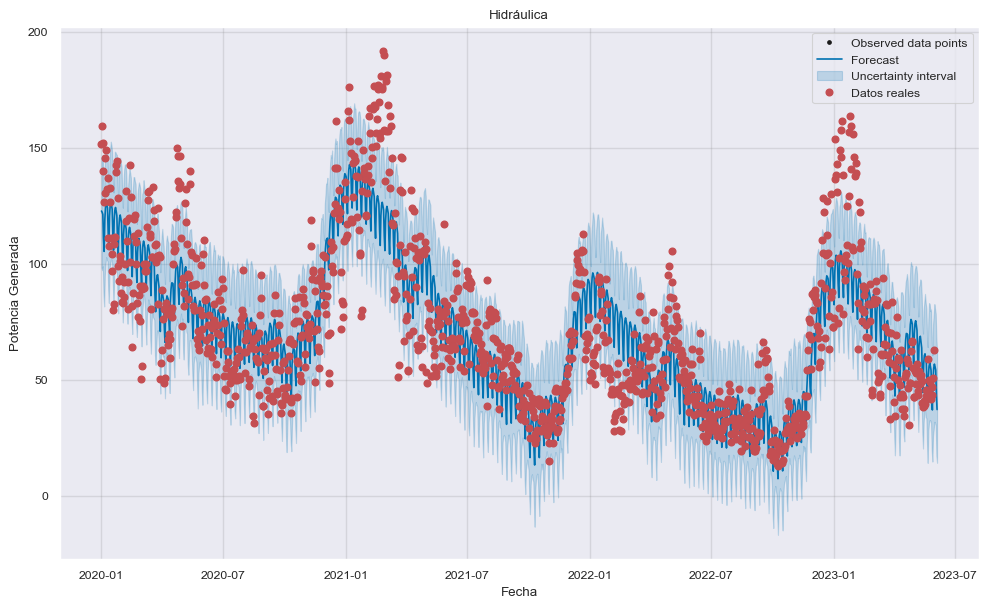

12:04:33 - cmdstanpy - INFO - Chain [1] start processing
12:04:33 - cmdstanpy - INFO - Chain [1] done processing


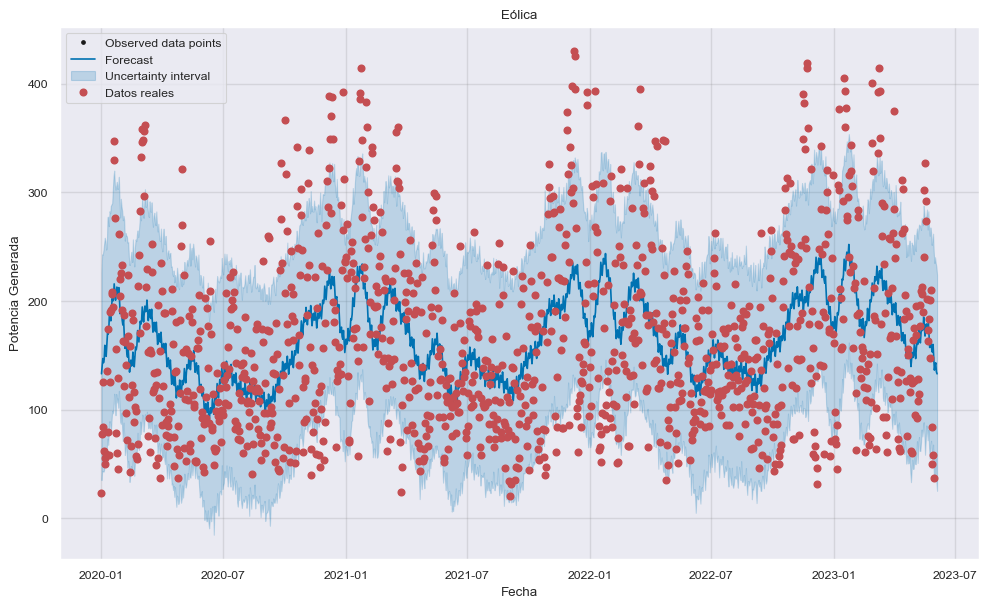

12:04:34 - cmdstanpy - INFO - Chain [1] start processing
12:04:34 - cmdstanpy - INFO - Chain [1] done processing


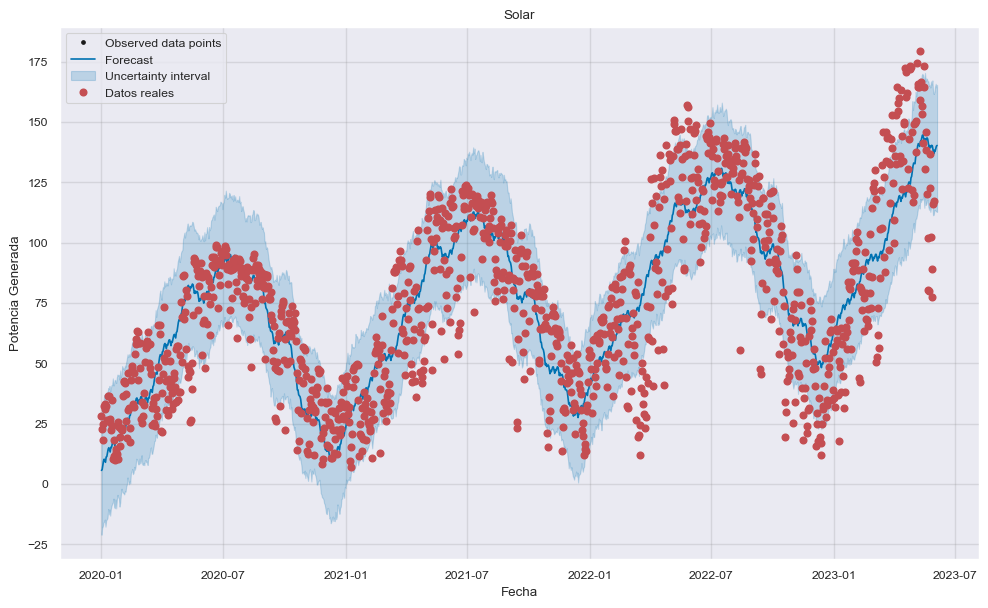

12:04:35 - cmdstanpy - INFO - Chain [1] start processing
12:04:35 - cmdstanpy - INFO - Chain [1] done processing


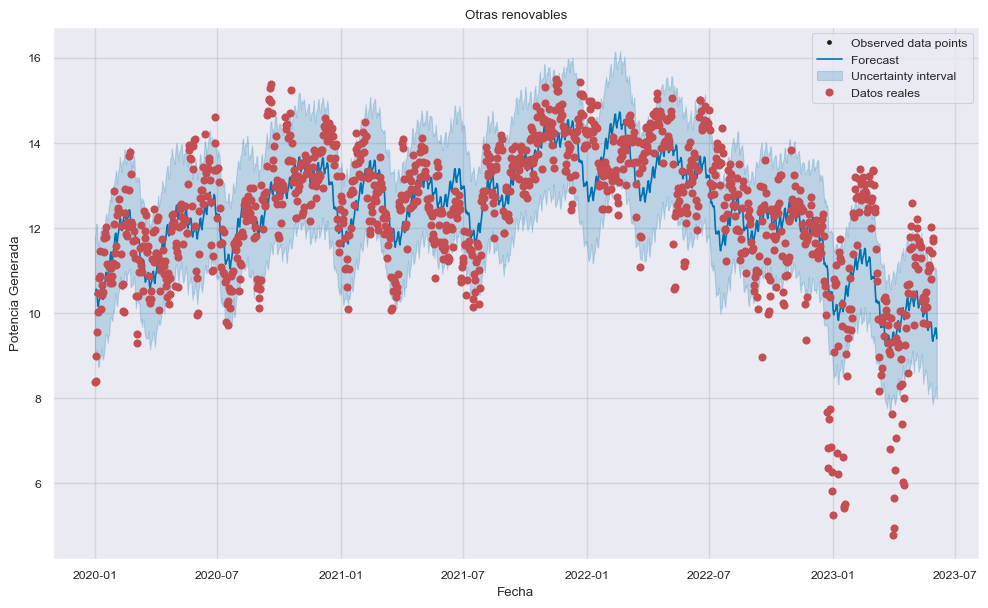

12:04:35 - cmdstanpy - INFO - Chain [1] start processing
12:04:36 - cmdstanpy - INFO - Chain [1] done processing


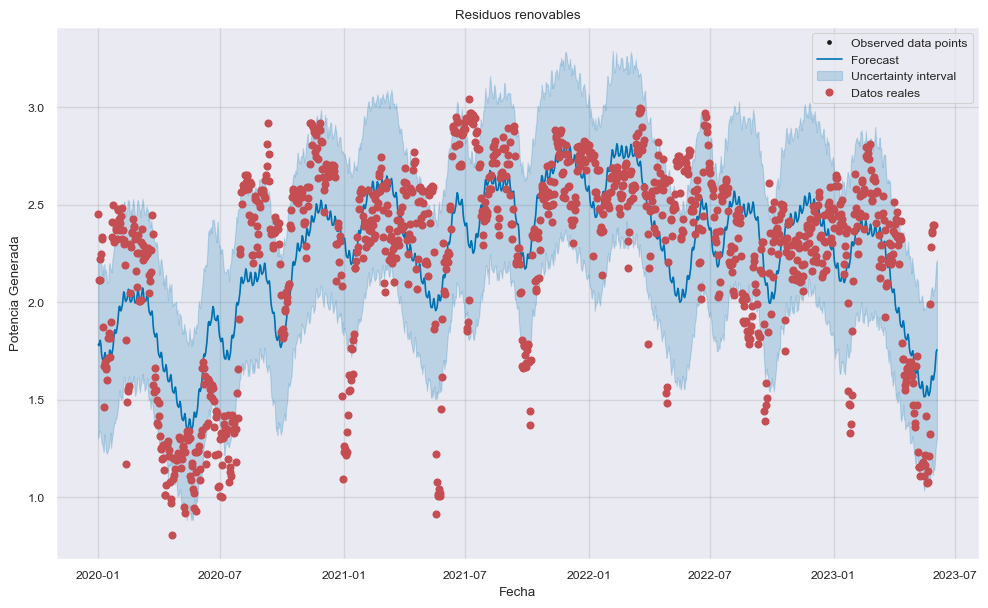

In [62]:
predicciones_df = pd.DataFrame(columns=['Fecha'] + columnas_potencia)

for columna in columnas_potencia:
    # Obtén los datos correspondientes a la columna actual
    datos = renovables[['Fecha', columna]].rename(columns={'Fecha': 'ds', columna: 'y'})

    # Crea un nuevo modelo Prophet
    modelo = Prophet()

    # Ajusta el modelo a los datos
    modelo.fit(datos)

    # Genera un DataFrame con las fechas futuras para realizar predicciones
    futuras_fechas = modelo.make_future_dataframe(periods=5)

    # Realiza las predicciones
    predicciones = modelo.predict(futuras_fechas)

    # Guarda los valores de predicción en el DataFrame
    predicciones_df[columna] = predicciones['yhat'].tail(5)

    # Grafica los resultados
    modelo.plot(predicciones, xlabel='Fecha', ylabel='Potencia Generada', figsize=(10, 6))
    plt.title(columna)
    
    # Obtén los datos reales correspondientes a los últimos 5 días
    datos_reales_columna = renovables[['Fecha', columna]].rename(columns={'Fecha': 'ds', columna: 'y'})
    
    # Grafica los datos reales
    plt.plot(datos_reales_columna['ds'], datos_reales_columna['y'], 'ro', label='Datos reales')
    plt.legend()
    plt.show()

# Agrega las fechas al DataFrame
predicciones_df['Fecha'] = futuras_fechas['ds'].tail(5)


In [63]:
predicciones_df

,Fecha,Hidráulica,Eólica,Solar,Otras renovables,Residuos renovables
1246,2023-05-31,56.701184,136.356825,138.255689,9.466501,1.627453
1247,2023-06-01,55.574051,140.505167,137.780534,9.530188,1.652430
1248,2023-06-02,54.135444,143.102506,138.817232,9.653081,1.700328
1249,2023-06-03,43.418605,134.873517,139.958295,9.649309,1.745749
1250,2023-06-04,37.121195,132.958959,140.242069,9.400750,1.756550


In [64]:
renovables.tail()

,Fecha,Hidráulica,Eólica,Otras renovables,Residuos renovables,Solar,year,month,day
1241,2023-05-26,41.6624,210.392500,10.79782,2.282750,102.242471,2023,5,26
1242,2023-05-27,46.7669,83.687496,12.02782,2.365950,77.627623,2023,5,27
1243,2023-05-28,43.5155,49.557405,11.40592,2.354900,88.999581,2023,5,28
1244,2023-05-29,50.8219,58.580648,11.76121,2.397725,115.868949,2023,5,29
1245,2023-05-30,62.8643,37.432230,11.70251,2.394800,117.387611,2023,5,30


### Exportando csv

In [65]:
renovables = renovables.drop(columns=['year', 'month', 'day'])
#renovables.to_csv('renovables_clean.csv')

In [66]:
filled_gasn = filled_gasn[pd.to_datetime(filled_gasn['Date']).dt.year >= 2020]
filled_gasn = filled_gasn.loc[:, ['Date', 'Close']]
#filled_gasn.to_csv('gasnatural_clean.csv')

In [67]:
filled_uranio = filled_uranio[pd.to_datetime(filled_uranio['Date']).dt.year >= 2020]
filled_uranio = filled_uranio.loc[:, ['Date', 'Close']]
#filled_uranio.to_csv('uranio_clean.csv')